# HEP Benchmark Query Q6

This follows the [IRIS-HEP benchmark](https://github.com/iris-hep/adl-benchmarks-index)
and the article [Evaluating Query Languages and Systems for High-Energy Physics Data](https://arxiv.org/abs/2104.12615)
and provides implementations of the benchmark tasks using Apache Spark.

The workload and data:
  - Benchmark jobs are implemented follwing [IRIS-HEP benchmark](https://github.com/iris-hep/adl-benchmarks-index)
  - The input data is a series of events from CMS opendata
  - The job output is typically a histogram 
  - See also https://github.com/LucaCanali/Miscellaneous/tree/master/Spark_Physics

Author and contact: Luca.Canali@cern.ch  
February, 2022


In [ ]:
# Start the Spark Session
# This uses local mode for simplicity
# The use of findspark is optional

import findspark
findspark.init("/home/luca/Spark/spark-3.2.1-bin-hadoop3.2")

from pyspark.sql import SparkSession
spark = (SparkSession.builder
         .appName("HEP benchmark")
         .master("local[4]")
         .config("spark.driver.memory", "8g")
         .config("spark.jars", "./scalaudf_2.12-0.1.jar")  # jar with the Scala UDFs
         .config("spark.jars.packages", "net.jafama:jafama:2.3.2")  # Faster math library for Scala UDFs
         .config("spark.sql.orc.enableNestedColumnVectorizedReader", "true")
         .getOrCreate()
        )


In [3]:
# Read data for the benchmark tasks
# download data as detailed at https://github.com/LucaCanali/Miscellaneous/tree/master/Spark_Physics

path = "/home/luca/HEP_benchmark/"

# input_data = "Run2012B_SingleMu.orc"
# use only 2GB of data, to speed up the execution
input_data = "Run2012B_SingleMu.orc/part-00000-8a1518ff-3a05-442d-a624-0ee27a9e6b50-c000.snappy.orc"

df_events = spark.read.orc(path + input_data)

df_events.printSchema()

print(f"Number of events: {df_events.count()}")

root
 |-- run: integer (nullable = true)
 |-- luminosityBlock: long (nullable = true)
 |-- event: long (nullable = true)
 |-- HLT_IsoMu24_eta2p1: boolean (nullable = true)
 |-- HLT_IsoMu24: boolean (nullable = true)
 |-- HLT_IsoMu17_eta2p1_LooseIsoPFTau20: boolean (nullable = true)
 |-- PV_npvs: integer (nullable = true)
 |-- PV_x: float (nullable = true)
 |-- PV_y: float (nullable = true)
 |-- PV_z: float (nullable = true)
 |-- nMuon: long (nullable = true)
 |-- Muon_pt: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_eta: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_phi: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_mass: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- Muon_charge: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- Muon_pfRelIso03_all: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- 

# Q6 - Solution 1: Offload all computations to Scala UDF
For events with at least three jets, plot the $𝑝_𝑇$ of the trijet
system four-momentum (i.e., any combination of three distinct jets within the same event) that has the invariant mass closest to 172.5 GeV in each event and plot the maximum
b-tagging discriminant value among the jets in this trijet.


In [4]:
# Select 3-Jet events and group Jet parameters together

df_events_q6 = ( df_events
                 .selectExpr("event", "arrays_zip(Jet_pt, Jet_eta, Jet_phi, Jet_mass, Jet_btag) as Jet")
                 .filter("nJet >= 3")
               )
                
df_events_q6.printSchema()

root
 |-- event: long (nullable = true)
 |-- Jet: array (nullable = true)
 |    |-- element: struct (containsNull = false)
 |    |    |-- Jet_pt: float (nullable = true)
 |    |    |-- Jet_eta: float (nullable = true)
 |    |    |-- Jet_phi: float (nullable = true)
 |    |    |-- Jet_mass: float (nullable = true)
 |    |    |-- Jet_btag: float (nullable = true)



In [5]:
# Register the Scala UDF
schema = "pt: float, btag: float"

spark.udf.registerJavaFunction("triJetSelectedPtBtag", "ch.cern.udf.triJetSelectedPtBtag", schema)

In [6]:
q6 = df_events_q6.selectExpr("triJetSelectedPtBtag(Jet) as trijet")

q6.printSchema()
q6.show(5, False)

root
 |-- trijet: struct (nullable = true)
 |    |-- pt: float (nullable = true)
 |    |-- btag: float (nullable = true)

+-----------------------+
|trijet                 |
+-----------------------+
|{21.191969, -1.0}      |
|{11.904238, 0.92060655}|
|{67.30781, 0.09140313} |
|{50.762405, 0.19420531}|
|{35.210625, 0.9639855} |
+-----------------------+
only showing top 5 rows



In [7]:
# Compute the histogram of trijet.btag
# The Spark function "width_bucket" is used to generate the histogram bucket number
# a groupBy operation with count is used to fill the histogram
# The result is a histogram with bins value and counts foreach bin (N_events)


min_val = 0
max_val = 1.0
num_bins = 100
step = (max_val - min_val) / num_bins

histogram_data = ( 
    q6
        .selectExpr(f"width_bucket(trijet.btag, {min_val}, {max_val}, {num_bins}) as bucket") 
        .groupBy("bucket")
        .count()
        .orderBy("bucket")
    )

# convert bucket number to the corresponding dimoun mass value
histogram_data = histogram_data.selectExpr(f"round({min_val} + (bucket - 1/2) * {step},2) as value", "count as N_events")


In [8]:
# The action toPandas() here triggers the computation.
# Histogram data is fetched into the driver as a Pandas Dataframe.

%time histogram_data_pandas=histogram_data.toPandas()


CPU times: user 248 ms, sys: 31.6 ms, total: 280 ms
Wall time: 1min 36s


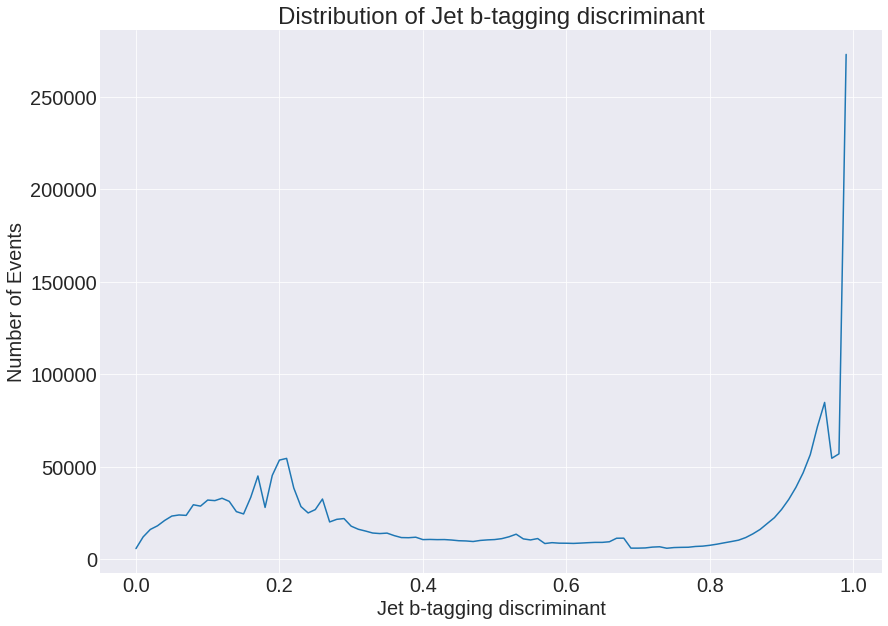

In [9]:
import matplotlib.pyplot as plt 
plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 20, 'figure.figsize': [14,10]})

# cut the first and last bin
x = histogram_data_pandas.iloc[1:-1]["value"]
y = histogram_data_pandas.iloc[1:-1]["N_events"]

# line plot
f, ax = plt.subplots()
ax.plot(x, y, '-')

ax.set_xlabel('Jet b-tagging discriminant')
ax.set_ylabel('Number of Events')
ax.set_title("Distribution of Jet b-tagging discriminant")

plt.show()

In [10]:
# compute the histogram of trijet.pt

min_val = 0
max_val = 200
num_bins = 100
step = (max_val - min_val) / num_bins

histogram_data = ( 
    q6
        .selectExpr(f"width_bucket(trijet.pt, {min_val}, {max_val}, {num_bins}) as bucket") 
        .groupBy("bucket")
        .count()
        .orderBy("bucket")
    )

# convert bucket number to the corresponding dimoun mass value
histogram_data = histogram_data.selectExpr(f"round({min_val} + (bucket - 1/2) * {step},2) as value", "count as N_events")


In [11]:
# The action toPandas() here triggers the computation.
# Histogram data is fetched into the driver as a Pandas Dataframe.

%time histogram_data_pandas=histogram_data.toPandas()


CPU times: user 36.8 ms, sys: 10.8 ms, total: 47.6 ms
Wall time: 1min 48s


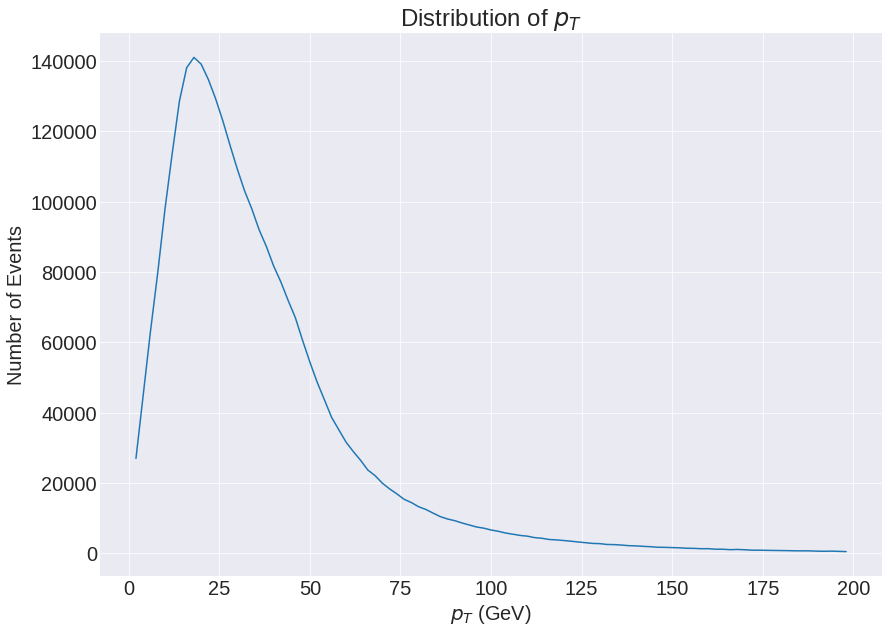

In [12]:
import matplotlib.pyplot as plt 
plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 20, 'figure.figsize': [14,10]})

# cut the first and last bin
x = histogram_data_pandas.iloc[1:-1]["value"]
y = histogram_data_pandas.iloc[1:-1]["N_events"]

# line plot
f, ax = plt.subplots()
ax.plot(x, y, '-')

ax.set_xlabel('$p_T$ (GeV)')
ax.set_ylabel('Number of Events')
ax.set_title("Distribution of $p_T$ ")

plt.show()

# Q6 - Solution 2: Compute 3-jet combinations and TriJet mass in Scala UDF
For events with at least three jets, plot the $𝑝_𝑇$ of the trijet
system four-momentum (i.e., any combination of three distinct jets within the same event) that has the invariant mass closest to 172.5 GeV in each event and plot the maximum
b-tagging discriminant value among the jets in this trijet.


In [13]:
# Select 3-Jet events and group Jet parameters together

df_events_q6 = ( df_events
                 .selectExpr("event", "arrays_zip(Jet_pt, Jet_eta, Jet_phi, Jet_mass, Jet_btag) as Jet")
                 .filter("nJet >= 3")
               )
                
df_events_q6.printSchema()


root
 |-- event: long (nullable = true)
 |-- Jet: array (nullable = true)
 |    |-- element: struct (containsNull = false)
 |    |    |-- Jet_pt: float (nullable = true)
 |    |    |-- Jet_eta: float (nullable = true)
 |    |    |-- Jet_phi: float (nullable = true)
 |    |    |-- Jet_mass: float (nullable = true)
 |    |    |-- Jet_btag: float (nullable = true)



In [14]:
# Register the Scala UDF

# Alternative schema definition
#from pyspark.sql.types import FloatType, ArrayType, StructType, StructField
#
#schema = ArrayType(ArrayType(StructType([
#    StructField('pt', FloatType(), nullable=True),
#    StructField('eta', FloatType(), nullable=True),
#    StructField('phi', FloatType(), nullable=True),
#    StructField('mass', FloatType(), nullable=True)
#])))

schema = "array<array<struct<Jet_pt:float, Jet_eta:float, Jet_phi:float, Jet_mass:float, Jet_btag:float>>>"

spark.udf.registerJavaFunction("array_combinations", "ch.cern.udf.array_combinations", schema)

In [15]:
# use the Scala UDF to produce the trijet combinations
df_jet_combinations = df_events_q6.selectExpr("array_combinations(Jet) as Jet_combinations")

df_jet_combinations.printSchema()


root
 |-- Jet_combinations: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- Jet_pt: float (nullable = true)
 |    |    |    |-- Jet_eta: float (nullable = true)
 |    |    |    |-- Jet_phi: float (nullable = true)
 |    |    |    |-- Jet_mass: float (nullable = true)
 |    |    |    |-- Jet_btag: float (nullable = true)



In [16]:
# Register the Scala UDF
from pyspark.sql.types import StructType, StructField, FloatType

schema = "struct<mass:float, pt:float, btag:float>"

spark.udf.registerJavaFunction("compute_triJet_pt_mass_delta_btag", "ch.cern.udf.triJetPtMassDeltaBtag", schema )


In [17]:
# Compute the triJet btag using a Scala UDF

df2 = df_jet_combinations.selectExpr("""
transform(Jet_combinations, trijet -> compute_triJet_pt_mass_delta_btag(trijet)) as trijet
""")

df2.printSchema()
# df2.show(3, False)

root
 |-- trijet: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- mass: float (nullable = true)
 |    |    |-- pt: float (nullable = true)
 |    |    |-- btag: float (nullable = true)



In [18]:
q6 = df2.selectExpr("array_min(trijet) as trijet")

q6.printSchema()
q6.show(5, False)
q6.count()

root
 |-- trijet: struct (nullable = true)
 |    |-- mass: float (nullable = true)
 |    |-- pt: float (nullable = true)
 |    |-- btag: float (nullable = true)

+----------------------------------+
|trijet                            |
+----------------------------------+
|{23.817657, 21.191969, -1.0}      |
|{69.457016, 11.904238, 0.92060655}|
|{203.42136, 67.30781, 0.09140313} |
|{6.258835, 50.762405, 0.19420531} |
|{12.777115, 35.210625, 0.9639855} |
+----------------------------------+
only showing top 5 rows



2995213

In [19]:
# compute the histogram

min_val = 0
max_val = 1
num_bins = 100
step = (max_val - min_val) / num_bins

histogram_data = ( 
    q6
        .selectExpr(f"width_bucket(trijet.btag, {min_val}, {max_val}, {num_bins}) as bucket") 
        .groupBy("bucket")
        .count()
        .orderBy("bucket")
    )

# convert bucket number to the corresponding dimoun mass value
histogram_data = histogram_data.selectExpr(f"round({min_val} + (bucket - 1/2) * {step},2) as value", "count as N_events")


In [20]:
# The action toPandas() here triggers the computation.
# Histogram data is fetched into the driver as a Pandas Dataframe.

%time histogram_data_pandas=histogram_data.toPandas()


CPU times: user 47.4 ms, sys: 12.7 ms, total: 60.1 ms
Wall time: 2min 59s


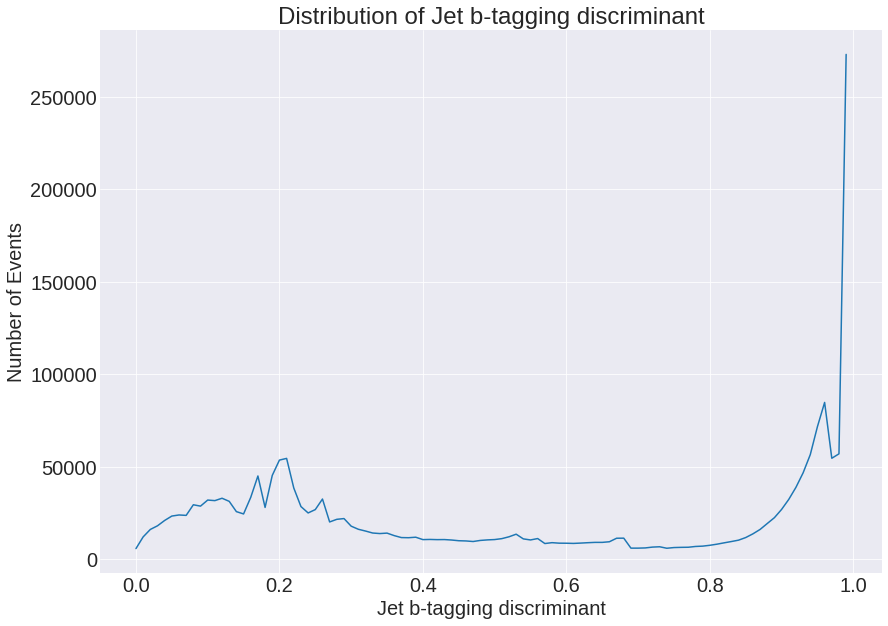

In [21]:
import matplotlib.pyplot as plt 
plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 20, 'figure.figsize': [14,10]})

# cut the first and last bin
x = histogram_data_pandas.iloc[1:-1]["value"]
y = histogram_data_pandas.iloc[1:-1]["N_events"]

# line plot
f, ax = plt.subplots()
ax.plot(x, y, '-')

ax.set_xlabel('Jet b-tagging discriminant')
ax.set_ylabel('Number of Events')
ax.set_title("Distribution of Jet b-tagging discriminant")

plt.show()

In [22]:
# compute the histogram

min_val = 0
max_val = 200
num_bins = 100
step = (max_val - min_val) / num_bins

histogram_data = ( 
    q6
        .selectExpr(f"width_bucket(trijet.pt, {min_val}, {max_val}, {num_bins}) as bucket") 
        .groupBy("bucket")
        .count()
        .orderBy("bucket")
    )

# convert bucket number to the corresponding dimoun mass value
histogram_data = histogram_data.selectExpr(f"round({min_val} + (bucket - 1/2) * {step},2) as value", "count as N_events")


In [23]:
# The action toPandas() here triggers the computation.
# Histogram data is fetched into the driver as a Pandas Dataframe.

%time histogram_data_pandas=histogram_data.toPandas()


CPU times: user 51 ms, sys: 14.1 ms, total: 65.1 ms
Wall time: 3min 1s


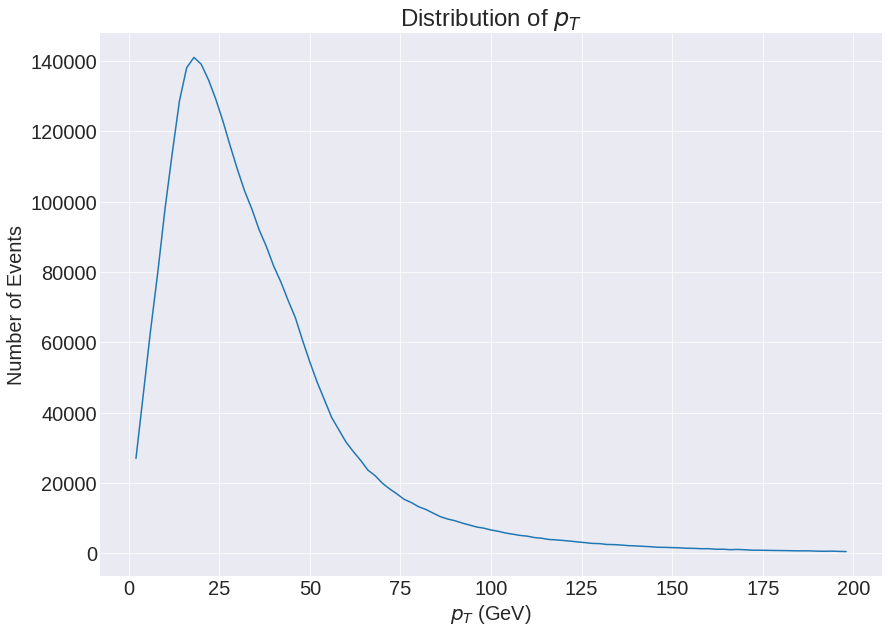

In [24]:
import matplotlib.pyplot as plt 
plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 20, 'figure.figsize': [14,10]})

# cut the first and last bin
x = histogram_data_pandas.iloc[1:-1]["value"]
y = histogram_data_pandas.iloc[1:-1]["N_events"]

# line plot
f, ax = plt.subplots()
ax.plot(x, y, '-')

ax.set_xlabel('$p_T$ (GeV)')
ax.set_ylabel('Number of Events')
ax.set_title("Distribution of $p_T$ ")

plt.show()

# Q6 - Solution 3: Only TriJet mass in Scala UDF
For events with at least three jets, plot the $𝑝_𝑇$ of the trijet
system four-momentum (i.e., any combination of three distinct jets within the same event) that has the invariant mass closest to 172.5 GeV in each event and plot the maximum
b-tagging discriminant value among the jets in this trijet.


In [25]:
# Select 3-Jet events and group Jet parameters together

df_events_q6 = ( df_events
                 .selectExpr("event", 
                             "arrays_zip(Jet_pt, Jet_eta, Jet_phi, Jet_mass, Jet_btag) as Jet")
                 .filter("nJet >= 3")
               )
                
df_events_q6.printSchema()


root
 |-- event: long (nullable = true)
 |-- Jet: array (nullable = true)
 |    |-- element: struct (containsNull = false)
 |    |    |-- Jet_pt: float (nullable = true)
 |    |    |-- Jet_eta: float (nullable = true)
 |    |    |-- Jet_phi: float (nullable = true)
 |    |    |-- Jet_mass: float (nullable = true)
 |    |    |-- Jet_btag: float (nullable = true)



In [26]:
df_events_q6.selectExpr("posexplode(Jet) as (pos, Jet)").show(5, False)

+---+----------------------------------------------------+
|pos|Jet                                                 |
+---+----------------------------------------------------+
|0  |{28.03698, -2.573142, -0.0039507723, 9.169433, -1.0}|
|1  |{20.425129, -0.6191127, 2.44285, 6.7956524, -1.0}   |
|2  |{18.646175, 2.5256636, 1.2553711, 5.9932246, -1.0}  |
|3  |{17.995762, -3.8685246, 1.146259, 5.420945, -10.0}  |
|4  |{17.04349, -3.4595842, 2.2116172, 5.1888537, -10.0} |
+---+----------------------------------------------------+
only showing top 5 rows



In [27]:
schema = "struct<mass:float, pt:float, btag: float>"

spark.udf.registerJavaFunction("compute_triJet_pt_mass_btag", "ch.cern.udf.triJetPtMassBtag", schema )

In [28]:
df_events_q6.createOrReplaceTempView("t1")

22/03/03 15:21:50 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [29]:
# explodes Jet data for all possible 3-jet combinations
# compute pt and mass with a UDF 
# filter for the desired combination

df_3jets = spark.sql("""
with triJet_all as (
  select e1 as event, compute_triJet_pt_mass_btag(j1.Jet, j2.Jet, j3.Jet) as triJet_pt_mass_btag
  from
    (select event e1, posexplode(Jet) as (pos, Jet) from t1) j1,
    (select event e2, posexplode(Jet) as (pos, Jet) from t1) j2,
    (select event e3, posexplode(Jet) as (pos, Jet) from t1) j3
  where
    j1.pos < j2.pos and j2.pos < j3.pos
    and e1 = e2 and e1 = e3
)
select event, triJet_pt_mass_btag, 
       rank() over (partition by event order by abs(triJet_pt_mass_btag.mass - 172.5)) triJet_rank
from triJet_all
""")


#df_3jets.show(10, False)

In [30]:
df_3jets_selected = df_3jets.filter("triJet_rank == 1")

df_3jets_selected.printSchema()
df_3jets_selected.show(5, False)


root
 |-- event: long (nullable = true)
 |-- triJet_pt_mass_btag: struct (nullable = true)
 |    |-- mass: float (nullable = true)
 |    |-- pt: float (nullable = true)
 |    |-- btag: float (nullable = true)
 |-- triJet_rank: integer (nullable = false)



+-----+----------------------------------+-----------+
|event|triJet_pt_mass_btag               |triJet_rank|
+-----+----------------------------------+-----------+
|16530|{171.6317, 36.551678, 0.31837988} |1          |
|17043|{276.50034, 40.94915, 0.025873112}|1          |
|21690|{125.49126, 7.7352033, 0.25450307}|1          |
|34408|{178.24324, 43.79818, 0.9780841}  |1          |
|57566|{129.27731, 12.640515, 0.3163859} |1          |
+-----+----------------------------------+-----------+
only showing top 5 rows



In [31]:
# compute the histogram

min_val = 0
max_val = 1
num_bins = 100
step = (max_val - min_val) / num_bins

histogram_data = ( 
    df_3jets_selected
        .selectExpr(f"width_bucket(triJet_pt_mass_btag.btag, {min_val}, {max_val}, {num_bins}) as bucket") 
        .groupBy("bucket")
        .count()
        .orderBy("bucket")
    )

# convert bucket number to the corresponding dimoun mass value
histogram_data = histogram_data.selectExpr(f"round({min_val} + (bucket - 1/2) * {step},2) as value", "count as N_events")


In [32]:
%time histogram_data_pandas=histogram_data.toPandas()


CPU times: user 120 ms, sys: 15.9 ms, total: 136 ms
Wall time: 2min 11s


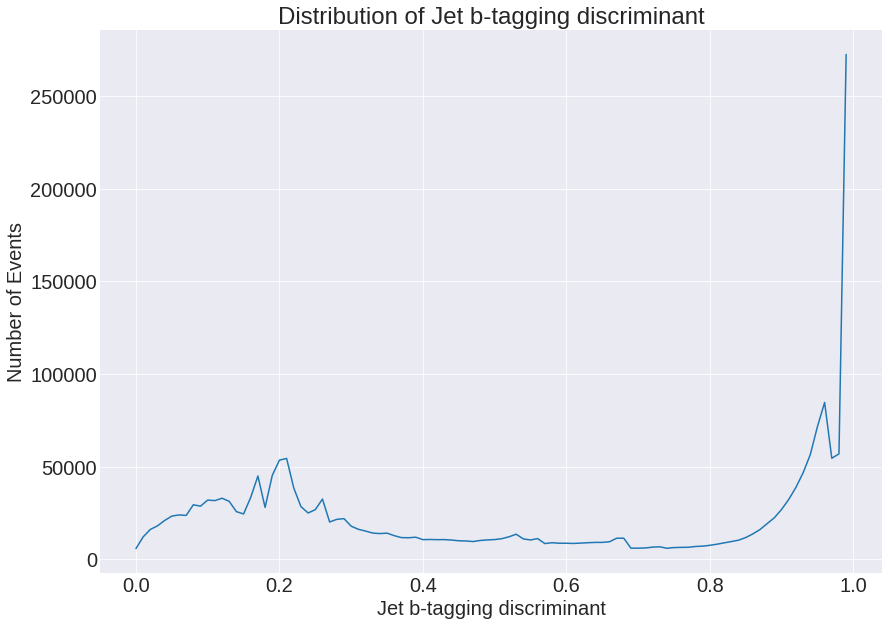

In [33]:
import matplotlib.pyplot as plt 
plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 20, 'figure.figsize': [14,10]})

# cut the first and last bin
x = histogram_data_pandas.iloc[1:-1]["value"]
y = histogram_data_pandas.iloc[1:-1]["N_events"]

# line plot
f, ax = plt.subplots()
ax.plot(x, y, '-')

ax.set_xlabel('Jet b-tagging discriminant')
ax.set_ylabel('Number of Events')
ax.set_title("Distribution of Jet b-tagging discriminant")

plt.show()

In [34]:
# compute the histogram

min_val = 0
max_val = 200
num_bins = 100
step = (max_val - min_val) / num_bins

histogram_data = ( 
    df_3jets_selected 
        .selectExpr(f"width_bucket(triJet_pt_mass_btag.pt, {min_val}, {max_val}, {num_bins}) as bucket") 
        .groupBy("bucket")
        .count()
        .orderBy("bucket")
    )

# convert bucket number to the corresponding dimoun mass value
histogram_data = histogram_data.selectExpr(f"round({min_val} + (bucket - 1/2) * {step},2) as value", "count as N_events")


In [35]:
%time histogram_data_pandas=histogram_data.toPandas()


CPU times: user 68.1 ms, sys: 19.3 ms, total: 87.4 ms
Wall time: 2min 11s


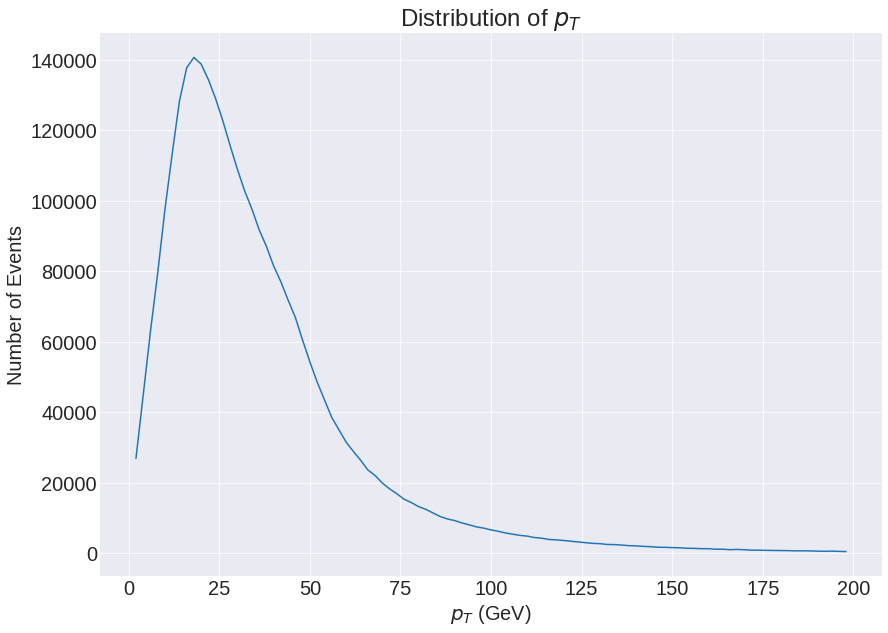

In [36]:
import matplotlib.pyplot as plt 
plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 20, 'figure.figsize': [14,10]})

# cut the first and last bin
x = histogram_data_pandas.iloc[1:-1]["value"]
y = histogram_data_pandas.iloc[1:-1]["N_events"]

# line plot
f, ax = plt.subplots()
ax.plot(x, y, '-')

ax.set_xlabel('$p_T$ (GeV)')
ax.set_ylabel('Number of Events')
ax.set_title("Distribution of $p_T$ ")

plt.show()

In [37]:
spark.stop()